In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
!pip install --upgrade scipy
#!pip install plotly==5.11.0
# %pip install --upgrade networkx[default]
# %pip install pyinform
# %conda install matplotlib
#%pip install bertopic


In [1]:
# reqruied libraries
import pandas as pd
import numpy as np
import datetime
import glob
import os
import re
import time
import datetime
#from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from bumpplot import bumpchart
#from bertopic import BERTopic

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from scipy import stats
import seaborn as sns

In [4]:
# s3 specific libraries
import s3fs
import boto3
s3 = s3fs.S3FileSystem(anon=False)

In [5]:
# Running with S3 (inside AWS) ?
RUNNING_IN_S3 = True

In [6]:
# Directories
OUTPUT_DIR = './OUTPUT'

UPLOAD_S3_BUCKET_NAME = 'mips-main'
UPLOAD_S3_BUCKET_SUBFOLDER = 'initial_data_collection/processed_data/actors_and_messages/v4'

#PC_INPUT_DIR = 'C:/STUFF/RESEARCH/Brandwatch/TEST'
PC_INPUT_DIR = 'C:/STUFF/RESEARCH/Brandwatch/DATA/MainQuery/All'
S3_INPUT_DIR = 's3://mips-main/initial_data_collection/raw_data/brandwatch'
INPUT_DIR = S3_INPUT_DIR if RUNNING_IN_S3 else PC_INPUT_DIR

S3_NEWS_DOMAINS_CSV_FILE = 's3://mips-main/initial_data_collection/news_outlets_v3.csv'
PC_NEWS_DOMAINS_CSV_FILE = 'C:/STUFF/RESEARCH/Brandwatch/DATA/news_outlets_v3.csv'
NEWS_DOMAINS_CSV_FILE = S3_NEWS_DOMAINS_CSV_FILE if RUNNING_IN_S3 else PC_NEWS_DOMAINS_CSV_FILE

S3_NEWS_DOMAIN_TUFM_FILE = 's3://mips-main/initial_data_collection/processed_data/news_sources/news_table-v2-UT60-FM5.csv'
PC_NEWS_DOMAIN_TUFM_FILE = 'C:/STUFF/RESEARCH/Brandwatch/DATA/news_table-v2-UT60-FM5.csv'
NEWS_DOMAIN_TUFM_FILE = S3_NEWS_DOMAIN_TUFM_FILE if RUNNING_IN_S3 else PC_NEWS_DOMAIN_TUFM_FILE

In [7]:
# Parameters
SAMPLE_FREQUENCY = 'D'

WINDOW_SHIFT_BY_DAYS = 1
INIT_WINDOW_SIZE = datetime.timedelta(days=4)
IS_GROWING_WINDOW = True # True if Growing, False if Moving

START_DATE = datetime.datetime(2018,3,1)
END_DATE = datetime.datetime(2018,5,1)

MIN_COMM_SIZE = 500
MIN_PLAT_SIZE = 50

KNOWN_PLATFORMS = {'twitter.com', 'tumblr.com', 'youtube.com', 'reddit.com', '4chan.org', 'facebook.com', 'gab.com'}

In [8]:
def read_csv_data(data_directory, filter_platform_domain_set, is_using_s3):
    """
    Reads data from all the csv files in the given directory
    :param data_directory: Path to the directory that contains the csv files
    :type data_directory: str
    :return: pandas Dataframe that contains all the data from all csv files
    :rtype: pd.Dataframe
    """
    data_files = []
    if is_using_s3:
        data_files = s3.glob(os.path.join(data_directory, "*.csv*"))
    else:
        data_files = glob.glob(os.path.join(data_directory, "*.csv*"))
    prefix_path = ''
    if is_using_s3:
        prefix_path = 's3://'
    print(data_files)
    df_list = []
    for idx, file in enumerate(data_files):
        print(f"Reading {idx + 1} of {len(data_files)} files.\nFile name: {file}")
        df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],
                         dtype={'Twitter Author ID': str, 'Author':str,
                                'Full Text':str, 'Title':str,
                                'Thread Id':str, 'Thread Author':str,
                                'Mentioned Authors':str,
                                'Domain':str, 'Expanded URLs':str,
                                'Avatar':str, 'Parent Blog Name':str, 'Root Blog Name':str})
        # df = df[['Date', 'Hashtags', 'Twitter Author ID', 'Author', 'Url', 'Thread Id', 'Thread Author', 'Domain']]
        df = df.rename(columns={'Date':'datetime', 'Author': 'source_user_id',
                                'Full Text':'content', 'Title':'title',
                                'Thread Id': 'parent_source_msg_id', 'Thread Author': 'parent_source_user_id',
                                'Mentioned Authors':'mentioned_source_user_id_list_str',
                                'Domain':'platform', 'Expanded URLs':'article_url'})
        df_list.append(df)
        #break #<<---------------------------------------------- REMOVE THIS
        
    start_time = time.time() 
    result_df = pd.concat(df_list)
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for concat dataframes")
    
    result_df['source_user_id'] = result_df['source_user_id'].apply(lambda x: x.lower() if type(x) is str else x)
    result_df['parent_source_user_id'] = result_df['parent_source_user_id'].apply(lambda x: x.lower() if type(x) is str else x)
    
    start_time = time.time() 
    result_df.drop_duplicates(subset='Url', keep="first", inplace=True)
    #result_df.drop_duplicates(keep="first", inplace=True)
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for drop duplicates")
    
    start_time = time.time()
    #result_df['platform'].value_counts().rename('posts_count').rename_axis('platform').to_csv(OUTPUT_DIR + "/platform_counts_info.csv")
    #result_df = result_df[result_df['platform'].isin(filter_platform_domain_set)]
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for filtering platforms")
    
    start_time = time.time()
    result_df['mentioned_source_user_id_list'] = result_df['mentioned_source_user_id_list_str'].apply(lambda x: [e[1:].lower() for e in x.split(', ')] if type(x) is str else [])
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for making lists of mentioned authors column : mentioned_source_user_id_list")
    
    result_df.reset_index(drop=True, inplace=True)
    print(result_df.shape)
    return result_df

In [9]:
%%time
# read data and filter for only the KNOWN_PLATFORMS
all_osn_msgs_df = read_csv_data(INPUT_DIR, KNOWN_PLATFORMS, RUNNING_IN_S3)
all_osn_msgs_df

['mips-main/initial_data_collection/raw_data/brandwatch/2018_03_01_to_2018_03_06_withFb_2033735572_MainQuery.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2018_03_07_withoutFb_2033735852_MIPs+test.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2020_05_02_2033753991_MainQuery_FbIgOnly.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2020_05_02_onlyFb_2033753991_MainQuery_FbIgOnly.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_08_to_2018_03_09_withoutFb_2033750044_MIPs+test.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_10_to_2018_03_12_withFb_2033755725_MainQuery.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_13_to_2018_03_13_withoutFb_2033770110_MainQuery_withoutFb.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_14_to_2018_03_14_withoutFb_2033776708_MainQuery_withoutFb.csv.zip', 'mips-main/i

/tmp/ipykernel_30536/2440928883.py:21: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],


Reading 7 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_13_to_2018_03_13_withoutFb_2033770110_MainQuery_withoutFb.csv.zip
Reading 8 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_14_to_2018_03_14_withoutFb_2033776708_MainQuery_withoutFb.csv.zip
Reading 9 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_15_to_2018_03_15_wihtoutFb_2033770779_MIPs+test.csv.zip
Reading 10 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_16_to_2018_03_16_withoutFb_2033798850_MIPs+test.csv.zip
Reading 11 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_17_to_2018_03_19_2033804694_MainQuery_withoutFb.csv.zip
Reading 12 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_20_to_2018_03_25_2033831837_MainQuery_withoutFb.csv.zip
Reading 13 of 22 files.
File name: mips-main/initial_data_collect

/tmp/ipykernel_30536/2440928883.py:21: DtypeWarning: Columns (62,77,110) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],


Reading 19 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_09_to_2018_04_11_withoutFb_2033968986_MIPs+test.csv.zip
Reading 20 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_12_to_2018_04_15_withoutFb_2033988828_MainQuery_withoutFb.csv.zip
Reading 21 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_16_to_2018_04_20_withoutFb_2034001178_MainQuery_withoutFb.csv.zip
Reading 22 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_21_to_2018_05_01_withoutFb_2034010661_MIPs+test.csv.zip
0.027960050106048583 mins for concat dataframes
0.04629226922988892 mins for drop duplicates
3.973642985026042e-09 mins for filtering platforms
0.021114663283030192 mins for making lists of mentioned authors column : mentioned_source_user_id_list
(1114424, 114)
CPU times: user 36.6 s, sys: 3.38 s, total: 39.9 s
Wall time: 56.9 s


,Query Id,Query Name,datetime,title,Url,platform,Sentiment,Page Type,Language,Country Code,...,Reddit Score,Reddit Score Upvote Ratio,Region,Region Code,Root Blog Name,Root Post Id,Subreddit,Subreddit Subscribers,Weblog Title,mentioned_source_user_id_list
0,2001100576,MainQuery,2018-03-06 23:59:57,RT @MarkUrban01 Sources: the poison used on Se...,http://twitter.com/melkaylan/statuses/97117357...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,melkaylan (melik kaylan),[]
1,2001100576,MainQuery,2018-03-06 23:59:50,RT @jimsciutto Keep watching this story: forme...,http://twitter.com/prutter_pat/statuses/971173...,twitter.com,neutral,twitter,en,CAN,...,NaN,NaN,Ontario,CAN.ON,NaN,NaN,NaN,NaN,prutter_pat (Pat Rutter),[]
2,2001100576,MainQuery,2018-03-06 23:59:49,RT @BBCTomSymonds Sergei Skripal’s 43 year old...,http://twitter.com/optouttwice/statuses/971173...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,optouttwice (OptOutTwice 🤔),[]
3,2001100576,MainQuery,2018-03-06 23:59:40,"RT @W7VOA Sergei Skripal, who is 66, was grant...",http://twitter.com/lindhays/statuses/971173499...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,Montana,USA.MT,NaN,NaN,NaN,NaN,lindhays (Democratic Socialism),[w7voa]
4,2001100576,MainQuery,2018-03-06 23:59:34,RT @KremlinTrolls **Relatives in Russia unable...,http://twitter.com/VedehiMajumdar/statuses/971...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VedehiMajumdar (Vedehi Majumdar),[kremlintrolls]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114419,2001099695,MIPs test,2018-04-21 00:00:00,NaN,https://hotcopper.com.au/threads/uk-gas-trail-...,hotcopper.com.au,negative,forum,en,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ophir,[]
1114420,2001099695,MIPs test,2018-04-21 00:00:00,"The Qanon posts, and a “Very Bad Day” Scenario...",http://projectavalon.net/forum4/showthread.php...,projectavalon.net,negative,forum,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cidersomerset,[]
1114421,2001099695,MIPs test,2018-04-21 00:00:00,"Russia Exposes British Lies On Skripal, But Tr...",http://revolutionradio.org/2018/04/21/russia-e...,revolutionradio.org,neutral,blog,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Russia Exposes British Lies On Skripal, But Tr...",[]
1114422,2001099695,MIPs test,2018-04-21 00:00:00,Syria air strikes: US and allies attack [alleg...,http://projectavalon.net/forum4/showthread.php...,projectavalon.net,negative,forum,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cidersomerset,[]


In [10]:
%%time
# add user_id column and parent_user_id column

def generate_users_dict(osn_msgs_df):
    global next_user_id
    users_data = {}
    next_user_id = 0
    def extract_user(row):
        global next_user_id
        if (row['platform'], row['source_user_id']) not in users_data:
            users_data[(row['platform'], row['source_user_id'])] = next_user_id
            next_user_id += 1
        if (row['platform'], row['parent_source_user_id']) not in users_data:
            users_data[(row['platform'], row['parent_source_user_id'])] = next_user_id
            next_user_id += 1
    all_osn_msgs_df.apply(lambda row: extract_user(row), axis=1)
    print(len(users_data))
    return users_data

users_data = generate_users_dict(all_osn_msgs_df)

users_df = pd.Series(users_data).rename_axis(['platform','source_user_id']).rename('user_id').reset_index()
print(users_df.shape)
#print(users_df)
#users_df.to_csv(OUTPUT_DIR + "/users.csv",index=False)

# add user_id column and parent_user_id column
all_osn_msgs_df[['user_id','parent_user_id']] = all_osn_msgs_df.apply(lambda row: pd.Series([
            users_data[(row['platform'],row['source_user_id'])],
            users_data[(row['platform'],row['parent_source_user_id'])]
        ]), axis = 1)

248856
(248856, 3)
CPU times: user 2min 37s, sys: 4.74 s, total: 2min 42s
Wall time: 2min 42s


In [11]:
def find_patterns_for_domains(in_news_domains_csv_file, in_add_splits=False, in_skip_strings=None):
    news_domains = pd.read_csv(in_news_domains_csv_file)['news outlets'].rename('news_outlets')
    news_domains_set = set(news_domains.to_list())
    pattern_to_news_domain_name = {re.compile(nd.replace('.','\.')):nd for nd in news_domains_set}
    if in_add_splits:
        for nd in news_domains_set:
            valid_split_strs = set(nd.split('.'))
            for e in in_skip_strings:
                valid_split_strs.discard(e)
            for sp in valid_split_strs:
                if len(sp) > 2:
                    pattern_to_news_domain_name[re.compile(sp)] = nd
    return pattern_to_news_domain_name

def search_domain_in_string(in_expanded_url, in_news_domains_names):
    # print(in_expanded_url)
    max_len_match = None
    max_len_found = 0
    for ndn in in_news_domains_names:
        match_obj = ndn.search(in_expanded_url)
        if match_obj:
            # print(match_obj, in_news_domains_names[ndn], match_obj.end() - match_obj.start())
            if max_len_found < match_obj.end() - match_obj.start():
                max_len_match = ndn
                max_len_found = match_obj.end() - match_obj.start()
    return in_news_domains_names[max_len_match] if max_len_match is not None else None


def calculate_news_domain_series(in_string_series, in_add_splits=False, in_skip_strings=None):
    news_domains_names = find_patterns_for_domains(NEWS_DOMAINS_CSV_FILE, in_add_splits, in_skip_strings)
    return in_string_series.apply(lambda x: search_domain_in_string(x, news_domains_names) if type(x) is str else None)


In [12]:
%%time
# Add news_domains column
all_osn_msgs_df['news_domain'] = calculate_news_domain_series(all_osn_msgs_df['article_url'])

#skip_strings = {'add', 'al', 'au', 'ca', 'com', 'es', 'in', 'is', 'it', 'ms', 'my', 'net', 'news', 'org', 'rs', 'st', 'tv', 'uk', 'us', 'co'}
#all_osn_msgs_df['news_domain_subs'] = calculate_news_domain_series(all_osn_msgs_df['article_url'], True, skip_strings)

# filter only the ones with requested domain names
all_osn_msgs_df = all_osn_msgs_df.loc[all_osn_msgs_df['news_domain'].notnull(), :]

print(f"Num of news domains found in data : {all_osn_msgs_df['news_domain'].nunique()}")

Num of news domains found in data : 267
CPU times: user 2min 20s, sys: 657 ms, total: 2min 21s
Wall time: 2min 21s


In [13]:
all_osn_msgs_df['platform'].unique()

array(['twitter.com'], dtype=object)

In [14]:
all_osn_msgs_df

,Query Id,Query Name,datetime,title,Url,platform,Sentiment,Page Type,Language,Country Code,...,Region Code,Root Blog Name,Root Post Id,Subreddit,Subreddit Subscribers,Weblog Title,mentioned_source_user_id_list,user_id,parent_user_id,news_domain
5,2001100576,MainQuery,2018-03-06 23:59:28,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/Tesscatbird/statuses/971173...,twitter.com,negative,twitter,en,USA,...,USA.CA,NaN,NaN,NaN,NaN,Tesscatbird (Tess),[],10,11,theguardian.com
7,2001100576,MainQuery,2018-03-06 23:59:01,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/crlulukat/statuses/97117333...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,crlulukat (Kathy 🌼),[],12,11,theguardian.com
9,2001100576,MainQuery,2018-03-06 23:58:36,"RT @NBCNews ""The man went stiff. His arms stop...",http://twitter.com/tiffanyclay/statuses/971173...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,tiffanyclay (❄️Evidence-Based Tiffany❄️),[],14,15,nbcnews.com
12,2001100576,MainQuery,2018-03-06 23:58:22,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/KarCranky/statuses/97117317...,twitter.com,negative,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,KarCranky (KarLen),[],19,11,theguardian.com
14,2001100576,MainQuery,2018-03-06 23:58:22,RT @andreariscassi Counter-terrorism police ta...,http://twitter.com/electricboyo/statuses/97117...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,electricboyo (Gregory Danner),[andreariscassi],22,23,theguardian.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114403,2001099695,MIPs test,2018-04-21 00:08:04,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/lawsonjessie301/statuses/98...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,lawsonjessie301 (ST Media Inc),[],35406,30,nytimes.com
1114404,2001099695,MIPs test,2018-04-21 00:08:04,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/NYT/statuses/98748306769361...,twitter.com,neutral,twitter,en,USA,...,USA.NY,NaN,NaN,NaN,NaN,NYT (NYT),[],380,30,nytimes.com
1114405,2001099695,MIPs test,2018-04-21 00:08:03,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/ElizabethFieshe/statuses/98...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,ElizabethFieshe (Pine Island Info Inc),[],35379,30,nytimes.com
1114412,2001099695,MIPs test,2018-04-21 00:02:57,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/danilina5886/statuses/98748...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,danilina5886 (danilina),[],35313,30,nytimes.com


## Measurements

In [15]:
""" Function for calculating network based measurements """
def calc_network_measurements(in_prefix, in_edge_list_df, in_source_col, in_target_col, in_weight_cols_list, in_max_k=200):
    measurements = {}
    # Betweenness Centrality
    measurement_name = f'{in_prefix}_BetCent'
    G_all = nx.from_pandas_edgelist(in_edge_list_df, in_source_col, in_target_col, in_weight_cols_list, create_using=nx.DiGraph())
    kval = min(G_all.number_of_nodes(), in_max_k)
    bc = nx.betweenness_centrality(G_all, k=kval)
    bc = pd.Series(bc).rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = bc
    
    # Outdegree in TE network
    measurement_name = f'{in_prefix}_OutDegree'
    tenet_outdegree = in_edge_list_df.groupby(in_source_col).count()[in_target_col].rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = tenet_outdegree
    
    # Total Outgoing Weights
    for weight in in_weight_cols_list:
        measurement_name = f'{in_prefix}_TotalOut{weight}'
        totaloutte = in_edge_list_df[[in_source_col,in_target_col,weight]].groupby(in_source_col).sum(weight).rename(columns={weight:measurement_name}).rename_axis('Source')
        measurements[measurement_name] = totaloutte
    
    return measurements

### Classical measurements

In [16]:
""" Function for calculating classical measurements based on raw OSN messages data"""
def classical_measurements(in_osn_msgs_df):
    measurements = {}
    
    # Received retweets
    received_retweets = in_osn_msgs_df['parent_source_user_id'].value_counts().rename_axis('Source').rename('ReceivedRetweets')
    measurements['ReceivedRetweets'] = received_retweets
    
    # Number of posts
    numposts = in_osn_msgs_df['source_user_id'].value_counts().rename_axis('Source').rename('NumPosts')
    measurements['NumPosts'] = numposts
    
    # Received mentions
    nummentions = {}
    def markCountedMention(e):
        if e in nummentions:
            nummentions[e] += 1
        else:
            nummentions[e] = 1
    in_osn_msgs_df['mentioned_source_user_id_list'].apply(lambda x: [markCountedMention(e) for e in x] )
    nummentions = pd.Series(nummentions).sort_values(ascending=False).rename('ReceivedMentions').rename_axis('Source')
    measurements['ReceivedMentions'] = nummentions
    
    # Received retweets or mentions
    numRTorMent = {}
    def markCountedRetOrMen(e):
        if e in numRTorMent:
            numRTorMent[e] += 1
        else:
            numRTorMent[e] = 1
    def markRetOrMent(x):
        if not x['parent_source_user_id'] is np.nan:
            markCountedRetOrMen(x['parent_source_user_id'])
        for e in x['mentioned_source_user_id_list']:
            if e != x['parent_source_user_id']:
                markCountedRetOrMen(e)
    in_osn_msgs_df[['parent_source_user_id','mentioned_source_user_id_list']].apply(lambda x: markRetOrMent(x), axis=1)
    numRTorMent = pd.Series(numRTorMent).sort_values(ascending=False).rename('ReceivedRetweetsOrMentions').rename_axis('Source')
    measurements['ReceivedRetweetsOrMentions'] = numRTorMent
    
    # Received retweets + mentions
    numretmen = pd.merge(received_retweets, nummentions, right_index = True, left_index = True)
    numretmen = numretmen['ReceivedRetweets'] + numretmen['ReceivedMentions']
    numretmen.rename('ReceivedRTs+Mentions', inplace=True)
    measurements['ReceivedRTs+Mentions'] = numretmen
    
    return measurements

In [17]:
%%time
all_measurements = classical_measurements( all_osn_msgs_df[(all_osn_msgs_df['datetime'] > datetime.datetime(2018,3,1)) & (all_osn_msgs_df['datetime'] <= datetime.datetime(2018,5,1))] )
all_measurements

CPU times: user 4.1 s, sys: 87.8 ms, total: 4.19 s
Wall time: 4.2 s


{'ReceivedRetweets': Source
 rt_com            26922
 craigmurrayorg    15284
 rtuknews           9209
 billbrowder        7747
 20committee        7058
                   ...  
 andrea_tarta          1
 domesticanimal        1
 sabry47314120         1
 presscoreca           1
 comradeyoza           1
 Name: ReceivedRetweets, Length: 9125, dtype: int64,
 'NumPosts': Source
 ferozwala         676
 rogue_corq        553
 rt_com            501
 rlsrussiannews    497
 mlnangalama       457
                  ... 
 biznesalert         1
 jeremyklodsky       1
 80jtl               1
 jay29ers            1
 dronestories        1
 Name: NumPosts, Length: 109468, dtype: int64,
 'ReceivedMentions': Source
 rt_com         15979
 20committee     7880
 independent     5524
 guardian        5042
 rtuknews        4526
                ...  
 djtinthemix        1
 zevshalev          1
 skepticsa          1
 dceiver            1
 daveg951           1
 Name: ReceivedMentions, Length: 8105, dtype: int64,
 

## Retweet Network data

In [18]:
%%time
dfrtedges = all_osn_msgs_df[all_osn_msgs_df['parent_source_user_id'].notnull()][['parent_source_user_id','source_user_id']].value_counts().rename('count').reset_index()
dfrtedges

CPU times: user 460 ms, sys: 56 ms, total: 516 ms
Wall time: 516 ms


,parent_source_user_id,source_user_id,count
0,rt_com,phildecarolis,255
1,rt_com,princessbibirf_,193
2,rt_com,news365247live,186
3,sjsrana,sjsrana,138
4,rt_com,djsiri,125
...,...,...,...
200969,gordoncorera,andre3verzaal,1
200970,gordoncorera,andreisoldatov,1
200971,gordoncorera,andrw100,1
200972,gordoncorera,andymoz78,1


In [19]:
%%time
RN_measurements = calc_network_measurements('RT', dfrtedges, 'parent_source_user_id', 'source_user_id', ['count'])
RN_measurements

CPU times: user 20.9 s, sys: 23.9 ms, total: 21 s
Wall time: 21 s


{'RT_BetCent': Source
 rt_com             0.000000e+00
 phildecarolis      0.000000e+00
 princessbibirf_    2.598428e-07
 news365247live     0.000000e+00
 sjsrana            0.000000e+00
                        ...     
 177fe3405b524bc    0.000000e+00
 abersrg            0.000000e+00
 alexanderjohnwg    0.000000e+00
 alphaque           0.000000e+00
 zvezdanews         0.000000e+00
 Name: RT_BetCent, Length: 96215, dtype: float64,
 'RT_OutDegree': Source
 007rukdme         2
 008moonside       2
 00exit            1
 024ab             1
 0406guno          2
                  ..
 zschneeweiss      5
 ztwx2015          1
 zuher64           4
 zunguzunguzeng    1
 zvezdanews        1
 Name: RT_OutDegree, Length: 9137, dtype: int64,
 'RT_TotalOutcount':                 RT_TotalOutcount
 Source                          
 007rukdme                      2
 008moonside                    2
 00exit                         1
 024ab                          2
 0406guno                       2
 ..

## TE Network data 

In [20]:
actorsdf = pd.read_csv('./OUTPUT/actors.csv', dtype={'actor_id':str,'actor_label':str})
actorsdf['actor_label'] = actorsdf['actor_label'].apply(lambda x: x.lower() if type(x) is str else x)
indv_actor_ids = set(actorsdf[(actorsdf['actor_type'] == 'indv') & (actorsdf['actor_id'] != '1')]['actor_id'])
actor_id_to_label = actorsdf.set_index('actor_id')['actor_label'].to_dict()
actorsdf

,actor_id,actor_label,actor_type,num_users
0,0,twitter.com,plat,415290
1,1,NaN,indv,1
2,2,rt_com,indv,1
3,3,craigmurrayorg,indv,1
4,4,billbrowder,indv,1
...,...,...,...,...
107,107,6,comm,8066
108,108,7,comm,5650
109,109,8,comm,4576
110,110,9,comm,3888


In [21]:
file_name = './OUTPUT/dynamic/growing/actor_te_edges_2018_03_01_2018_05_01.csv'
dfedges = pd.read_csv(file_name, dtype={'Source':str, 'Target':str})
dfedges = dfedges[dfedges['Source'].isin(indv_actor_ids) & dfedges['Target'].isin(indv_actor_ids)]
dfedges['Source'] = dfedges['Source'].apply(lambda x: actor_id_to_label[x])
dfedges['Target'] = dfedges['Target'].apply(lambda x: actor_id_to_label[x])
dfedges

,Source,Target,UF_UF,UF_UM,UF_TF,UF_TM,UM_UF,UM_UM,UM_TF,UM_TM,TF_UF,TF_UM,TF_TF,TF_TM,TM_UF,TM_UM,TM_TF,TM_TM,total_te
224,rt_com,craigmurrayorg,0.00000,0.000000,0.000000,0.000000,0.030480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033268,0.000000,0.000000,0.000000,0.063748
225,rt_com,billbrowder,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003879,0.000406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000809,0.027277,0.032371
226,rt_com,rtuknews,0.00000,0.000000,0.000000,0.000000,0.000000,0.053627,0.000000,0.003879,0.000000,0.000000,0.000000,0.000000,0.000000,0.011726,0.000000,0.000401,0.069633
227,rt_com,neilclark66,0.00000,0.000000,0.000000,0.000000,0.007021,0.037033,0.003879,0.042361,0.000000,0.000000,0.000000,0.000000,0.001660,0.013492,0.087500,0.003388,0.196334
228,rt_com,20committee,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001538,0.022854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,peterpobjecky,ninabyzantina,0.00296,0.002960,0.002514,0.004909,0.028946,0.009098,0.009098,0.048556,0.000809,0.000809,0.000401,0.002233,0.016594,0.016594,0.015805,0.003624,0.165911
11196,peterpobjecky,malinka1102,0.02251,0.040558,0.002514,0.006293,0.029745,0.067972,0.009098,0.097258,0.041982,0.023019,0.000401,0.032828,0.063249,0.065417,0.015805,0.038656,0.557305
11197,peterpobjecky,kenroth,0.00000,0.000000,0.000000,0.003063,0.000000,0.000000,0.000000,0.030764,0.000000,0.000000,0.000000,0.006354,0.000000,0.000000,0.000000,0.021053,0.061235
11198,peterpobjecky,benjaminnorton,0.00000,0.000000,0.002960,0.000000,0.000000,0.000000,0.009098,0.000000,0.000000,0.000000,0.000809,0.000000,0.000000,0.000000,0.017410,0.000000,0.030277


In [22]:
dfedges_filtered = dfedges[dfedges['total_te'] > 0.1][['Source','Target','total_te']]
dfedges_filtered.rename(columns={'total_te': 'TEsum'}, inplace=True)
dfedges_filtered

,Source,Target,TEsum
227,rt_com,neilclark66,0.196334
229,rt_com,shoebridgec,0.116269
233,rt_com,ian56789,0.359970
239,rt_com,kremlintrolls,0.163431
244,rt_com,naj562,0.162753
...,...,...,...
11192,peterpobjecky,piersrobinson1,0.264419
11194,peterpobjecky,hepworthclare,0.256597
11195,peterpobjecky,ninabyzantina,0.165911
11196,peterpobjecky,malinka1102,0.557305


In [23]:
%%time
TE_measurements = calc_network_measurements('TE', dfedges_filtered, 'Source', 'Target', ['TEsum'])
TE_measurements

CPU times: user 48.9 ms, sys: 22 µs, total: 48.9 ms
Wall time: 48.8 ms


{'TE_BetCent': Source
 rt_com            0.002513
 neilclark66       0.017046
 shoebridgec       0.039494
 ian56789          0.054928
 kremlintrolls     0.022204
                     ...   
 mollymckew        0.000008
 olganyc1211       0.000000
 pickardje         0.000414
 julianassange     0.000250
 thatginamiller    0.000000
 Name: TE_BetCent, Length: 97, dtype: float64,
 'TE_OutDegree': Source
 20committee       12
 _irishrepublic    55
 ajenglish          8
 ap                12
 bbcbreaking       11
                   ..
 vanessabeeley     35
 washingtonpost    14
 wsj               21
 yashar             5
 zerohedge          6
 Name: TE_OutDegree, Length: 95, dtype: int64,
 'TE_TotalOutTEsum':                 TE_TotalOutTEsum
 Source                          
 20committee             1.634712
 _irishrepublic         12.200763
 ajenglish               1.162192
 ap                      1.627824
 bbcbreaking             1.486605
 ...                          ...
 vanessabeeley    

## Comparison of measurements

In [24]:
%%time
all_measurements.update(TE_measurements)
all_measurements.update(RN_measurements)
all_measurements

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16.5 µs


{'ReceivedRetweets': Source
 rt_com            26922
 craigmurrayorg    15284
 rtuknews           9209
 billbrowder        7747
 20committee        7058
                   ...  
 andrea_tarta          1
 domesticanimal        1
 sabry47314120         1
 presscoreca           1
 comradeyoza           1
 Name: ReceivedRetweets, Length: 9125, dtype: int64,
 'NumPosts': Source
 ferozwala         676
 rogue_corq        553
 rt_com            501
 rlsrussiannews    497
 mlnangalama       457
                  ... 
 biznesalert         1
 jeremyklodsky       1
 80jtl               1
 jay29ers            1
 dronestories        1
 Name: NumPosts, Length: 109468, dtype: int64,
 'ReceivedMentions': Source
 rt_com         15979
 20committee     7880
 independent     5524
 guardian        5042
 rtuknews        4526
                ...  
 djtinthemix        1
 zevshalev          1
 skepticsa          1
 dceiver            1
 daveg951           1
 Name: ReceivedMentions, Length: 8105, dtype: int64,
 

In [25]:
""" Function for combining measurements """
def combine_measurements(in_measurements):
    # combine by merging the measurements
    keys_list = list(in_measurements.keys())
    key = keys_list[0]
    df = pd.DataFrame(in_measurements[key])
    for idx in range(1, len(keys_list)):
        key = keys_list[idx]
        df = df.merge(in_measurements[key], how='outer', on='Source')
    df.fillna(0, inplace=True)
    
   

    return df

def add_ranked_columns(inout_df_measurements, in_measurement_cols):
    # add a ranked column for each measurement
    measuremnts_list = list(in_measurement_cols)
    measurment_ranks_list = []
    for msmnt in measuremnts_list:
        msmnt_rank_name = f"{msmnt}_Rank"
        inout_df_measurements[msmnt_rank_name] = inout_df_measurements[msmnt].rank(ascending=False)
        measurment_ranks_list.append(msmnt_rank_name)
    print(f"Returning added ranked colum names: {measurment_ranks_list}")
    return measurment_ranks_list

In [26]:
df_measurements = combine_measurements(all_measurements)
ranked_measurements = add_ranked_columns(df_measurements, all_measurements.keys())
df_measurements

Returning added ranked colum names: ['ReceivedRetweets_Rank', 'NumPosts_Rank', 'ReceivedMentions_Rank', 'ReceivedRetweetsOrMentions_Rank', 'ReceivedRTs+Mentions_Rank', 'TE_BetCent_Rank', 'TE_OutDegree_Rank', 'TE_TotalOutTEsum_Rank', 'RT_BetCent_Rank', 'RT_OutDegree_Rank', 'RT_TotalOutcount_Rank']


,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TE_BetCent,TE_OutDegree,TE_TotalOutTEsum,RT_BetCent,RT_OutDegree,...,NumPosts_Rank,ReceivedMentions_Rank,ReceivedRetweetsOrMentions_Rank,ReceivedRTs+Mentions_Rank,TE_BetCent_Rank,TE_OutDegree_Rank,TE_TotalOutTEsum_Rank,RT_BetCent_Rank,RT_OutDegree_Rank,RT_TotalOutcount_Rank
Source,,,,,,,,,,,,,,,,,,,,,
rt_com,26922.0,501.0,15979.0,28142.0,42901.0,0.002513,31.0,4.939304,0.000000,10459.0,...,3.0,1.0,1.0,1.0,40.0,27.5,30.0,57294.0,1.0,1.0
craigmurrayorg,15284.0,22.0,4521.0,19316.0,19805.0,0.000459,9.0,1.056938,0.000000,7432.0,...,1998.0,6.0,2.0,2.0,61.0,68.0,72.0,57294.0,2.0,2.0
rtuknews,9209.0,210.0,4526.0,9335.0,13735.0,0.006996,33.0,5.796231,0.000000,4386.0,...,26.0,5.0,3.0,4.0,27.0,22.0,26.0,57294.0,5.0,3.0
billbrowder,7747.0,7.0,110.0,7856.0,7857.0,0.001930,21.0,3.130252,0.000000,6331.0,...,9263.0,192.0,5.0,10.0,42.0,41.0,40.0,57294.0,3.0,4.0
20committee,7058.0,36.0,7880.0,8033.0,14938.0,0.000269,12.0,1.634712,0.001439,4268.0,...,905.5,2.0,4.0,3.0,67.0,61.5,62.0,3.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
padraigpostal,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,60406.0,62032.5,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0
arrghgtr,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,60406.0,62032.5,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0
absolute_intj,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,60406.0,62032.5,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0


In [27]:
actor_of_interest = set()
for rankCol in ranked_measurements:
    actor_of_interest.update( set(df_measurements[df_measurements[rankCol] <= 100].index) )
print(len(actor_of_interest))
actor_of_interest

319


{'10downingstreet',
 '20committee',
 '5150power',
 '55krissi55',
 '_dpaj',
 '_irishrepublic',
 '_jakubjanda',
 '_nomoreexcuses',
 '_thepage',
 'a_rockas',
 'aauk41',
 'afp',
 'ajenews',
 'ajenglish',
 'alanmcpartlands',
 'ali9l9',
 'alihadi68',
 'amb_yakovenko',
 'andersblinde',
 'andrew__roth',
 'anon_decoder',
 'anthony18602671',
 'ap',
 'atamansikka',
 'axios',
 'bbcbreaking',
 'bbcnews',
 'bbcworld',
 'benjaminnorton',
 'benjaminwittes',
 'billbrowder',
 'bjarnekim',
 'bodhibrian',
 'bolshevik1953',
 'borisjohnson',
 "borisjohnson's",
 'bot_political',
 'brexiteerbrian',
 'brought_to_you',
 'bruno_paul',
 'businessinsider',
 'bv',
 'caitoz',
 'carlaspade',
 'carolehope2',
 'cbcalerts',
 'cbsnews',
 'cgnetwork',
 'charlesortel',
 'christopherjm',
 'city_affairs',
 'cnn',
 'cnnbrk',
 'cnni',
 'conservatives',
 'corbyn50plus',
 'craigmurrayorg',
 'cyril_matvech',
 'dailymailuk',
 'dancardenmp',
 'david_clarke91',
 'davies42g',
 'defendingdemo',
 'defygreed',
 'derbychrisw',
 'dgaytand

In [28]:
df_measurements = df_measurements[df_measurements.index.isin(actor_of_interest)]
df_measurements

,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TE_BetCent,TE_OutDegree,TE_TotalOutTEsum,RT_BetCent,RT_OutDegree,...,NumPosts_Rank,ReceivedMentions_Rank,ReceivedRetweetsOrMentions_Rank,ReceivedRTs+Mentions_Rank,TE_BetCent_Rank,TE_OutDegree_Rank,TE_TotalOutTEsum_Rank,RT_BetCent_Rank,RT_OutDegree_Rank,RT_TotalOutcount_Rank
Source,,,,,,,,,,,,,,,,,,,,,
rt_com,26922.0,501.0,15979.0,28142.0,42901.0,0.002513,31.0,4.939304,0.000000,10459.0,...,3.0,1.0,1.0,1.0,40.0,27.5,30.0,57294.0,1.0,1.0
craigmurrayorg,15284.0,22.0,4521.0,19316.0,19805.0,0.000459,9.0,1.056938,0.000000,7432.0,...,1998.0,6.0,2.0,2.0,61.0,68.0,72.0,57294.0,2.0,2.0
rtuknews,9209.0,210.0,4526.0,9335.0,13735.0,0.006996,33.0,5.796231,0.000000,4386.0,...,26.0,5.0,3.0,4.0,27.0,22.0,26.0,57294.0,5.0,3.0
billbrowder,7747.0,7.0,110.0,7856.0,7857.0,0.001930,21.0,3.130252,0.000000,6331.0,...,9263.0,192.0,5.0,10.0,42.0,41.0,40.0,57294.0,3.0,4.0
20committee,7058.0,36.0,7880.0,8033.0,14938.0,0.000269,12.0,1.634712,0.001439,4268.0,...,905.5,2.0,4.0,3.0,67.0,61.5,62.0,3.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ofcom,0.0,0.0,593.0,593.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,44.0,79.0,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0
parallelpond,0.0,0.0,518.0,518.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,53.0,93.5,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0
potus,0.0,0.0,334.0,334.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,111087.5,70.0,138.5,59289.5,56398.5,56401.0,56401.0,57294.0,60922.0,60922.0


In [29]:
%%time
measurementCols = list(all_measurements.keys())
srcdf = []
for colx in measurementCols:
    for coly in measurementCols:
        #if colx == coly:
        #    continue
        x = df_measurements[colx]
        y = df_measurements[coly]
        print(f"{colx} -> {coly}")
        def statistic(x):  # permute only `x`
            return stats.spearmanr(x, y).statistic
        res_exact = stats.permutation_test((x,), statistic,
                                           permutation_type='pairings')
        res_asymptotic = stats.spearmanr(x, y)
        print(f"Exact: spearmen ranked correlation value = {res_exact.statistic}, pvalue = {res_exact.pvalue}")
        print(f"Asymptotic: spearmen ranked correlation value = {res_asymptotic.statistic}, pvalue = {res_asymptotic.pvalue}")
        # asymptotic pvalue is too low
        srcdf.append([colx, coly, res_exact.statistic, res_exact.pvalue])
        
srcdf

ReceivedRetweets -> ReceivedRetweets
Exact: spearmen ranked correlation value = 1.0, pvalue = 0.0002
Asymptotic: spearmen ranked correlation value = 1.0, pvalue = 0.0
ReceivedRetweets -> NumPosts
Exact: spearmen ranked correlation value = -0.23735585424305083, pvalue = 0.0002
Asymptotic: spearmen ranked correlation value = -0.23735585424305083, pvalue = 1.835245666125815e-05
ReceivedRetweets -> ReceivedMentions
Exact: spearmen ranked correlation value = 0.4830438144001937, pvalue = 0.0002
Asymptotic: spearmen ranked correlation value = 0.4830438144001937, pvalue = 4.7102112519526666e-20
ReceivedRetweets -> ReceivedRetweetsOrMentions
Exact: spearmen ranked correlation value = 0.8052817883189987, pvalue = 0.0002
Asymptotic: spearmen ranked correlation value = 0.8052817883189987, pvalue = 5.993900306493588e-74
ReceivedRetweets -> ReceivedRTs+Mentions
Exact: spearmen ranked correlation value = 0.7918185629380479, pvalue = 0.0002
Asymptotic: spearmen ranked correlation value = 0.79181856293

[['ReceivedRetweets', 'ReceivedRetweets', 1.0, 0.0002],
 ['ReceivedRetweets', 'NumPosts', -0.23735585424305083, 0.0002],
 ['ReceivedRetweets', 'ReceivedMentions', 0.4830438144001937, 0.0002],
 ['ReceivedRetweets',
  'ReceivedRetweetsOrMentions',
  0.8052817883189987,
  0.0002],
 ['ReceivedRetweets', 'ReceivedRTs+Mentions', 0.7918185629380479, 0.0002],
 ['ReceivedRetweets', 'TE_BetCent', 0.6667960863845493, 0.0002],
 ['ReceivedRetweets', 'TE_OutDegree', 0.6729050468542478, 0.0002],
 ['ReceivedRetweets', 'TE_TotalOutTEsum', 0.6733660973743981, 0.0002],
 ['ReceivedRetweets', 'RT_BetCent', 0.0852853162620106, 0.1384],
 ['ReceivedRetweets', 'RT_OutDegree', 0.9948244831235843, 0.0002],
 ['ReceivedRetweets', 'RT_TotalOutcount', 0.9998086101381712, 0.0002],
 ['NumPosts', 'ReceivedRetweets', -0.23735585424305083, 0.0002],
 ['NumPosts', 'NumPosts', 1.0, 0.0002],
 ['NumPosts', 'ReceivedMentions', -0.3222130240207724, 0.0002],
 ['NumPosts', 'ReceivedRetweetsOrMentions', -0.4975243358488753, 0.0002

In [30]:
srcdf = pd.DataFrame(srcdf, columns=['x','y', 'SRC', 'pval'])

In [31]:
srcdf

,x,y,SRC,pval
0,ReceivedRetweets,ReceivedRetweets,1.000000,0.0002
1,ReceivedRetweets,NumPosts,-0.237356,0.0002
2,ReceivedRetweets,ReceivedMentions,0.483044,0.0002
3,ReceivedRetweets,ReceivedRetweetsOrMentions,0.805282,0.0002
4,ReceivedRetweets,ReceivedRTs+Mentions,0.791819,0.0002
...,...,...,...,...
116,RT_TotalOutcount,TE_OutDegree,0.674894,0.0002
117,RT_TotalOutcount,TE_TotalOutTEsum,0.675433,0.0002
118,RT_TotalOutcount,RT_BetCent,0.086676,0.1222
119,RT_TotalOutcount,RT_OutDegree,0.994825,0.0002


In [32]:
orderedMeasures = measurementCols

In [33]:
srcpivot = srcdf.pivot(index='x', columns='y', values='SRC')
srcpivot = srcpivot.loc[orderedMeasures,orderedMeasures]
srcpivot

y,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TE_BetCent,TE_OutDegree,TE_TotalOutTEsum,RT_BetCent,RT_OutDegree,RT_TotalOutcount
x,,,,,,,,,,,
ReceivedRetweets,1.000000,-0.237356,0.483044,0.805282,0.791819,0.666796,0.672905,0.673366,0.085285,0.994824,0.999809
NumPosts,-0.237356,1.000000,-0.322213,-0.497524,-0.321116,-0.160524,-0.182277,-0.182309,0.110366,-0.266097,-0.236137
ReceivedMentions,0.483044,-0.322213,1.000000,0.759850,0.802623,0.310284,0.310164,0.310141,-0.073025,0.482965,0.483854
ReceivedRetweetsOrMentions,0.805282,-0.497524,0.759850,1.000000,0.882153,0.586251,0.591826,0.592129,-0.095836,0.802085,0.805477
ReceivedRTs+Mentions,0.791819,-0.321116,0.802623,0.882153,1.000000,0.562195,0.572202,0.572428,-0.052484,0.791919,0.792300
TE_BetCent,0.666796,-0.160524,0.310284,0.586251,0.562195,1.000000,0.977200,0.977454,-0.036181,0.660661,0.668987
TE_OutDegree,0.672905,-0.182277,0.310164,0.591826,0.572202,0.977200,1.000000,0.999836,-0.049796,0.667856,0.674894
TE_TotalOutTEsum,0.673366,-0.182309,0.310141,0.592129,0.572428,0.977454,0.999836,1.000000,-0.047255,0.668290,0.675433
RT_BetCent,0.085285,0.110366,-0.073025,-0.095836,-0.052484,-0.036181,-0.049796,-0.047255,1.000000,0.089810,0.086676


In [34]:
srcpivot2 = srcdf.pivot(index='x', columns='y', values='pval')
srcpivot2 = srcpivot2.loc[orderedMeasures,orderedMeasures]
srcpivot2

y,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TE_BetCent,TE_OutDegree,TE_TotalOutTEsum,RT_BetCent,RT_OutDegree,RT_TotalOutcount
x,,,,,,,,,,,
ReceivedRetweets,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.1384,0.0002,0.0002
NumPosts,0.0002,0.0002,0.0002,0.0002,0.0002,0.0050,0.0008,0.0016,0.0538,0.0002,0.0002
ReceivedMentions,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.2058,0.0002,0.0002
ReceivedRetweetsOrMentions,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0900,0.0002,0.0002
ReceivedRTs+Mentions,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.3484,0.0002,0.0002
TE_BetCent,0.0002,0.0034,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.5416,0.0002,0.0002
TE_OutDegree,0.0002,0.0010,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.3792,0.0002,0.0002
TE_TotalOutTEsum,0.0002,0.0012,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.3942,0.0002,0.0002
RT_BetCent,0.1220,0.0488,0.1934,0.0920,0.3442,0.5072,0.3854,0.3952,0.0002,0.1138,0.1302


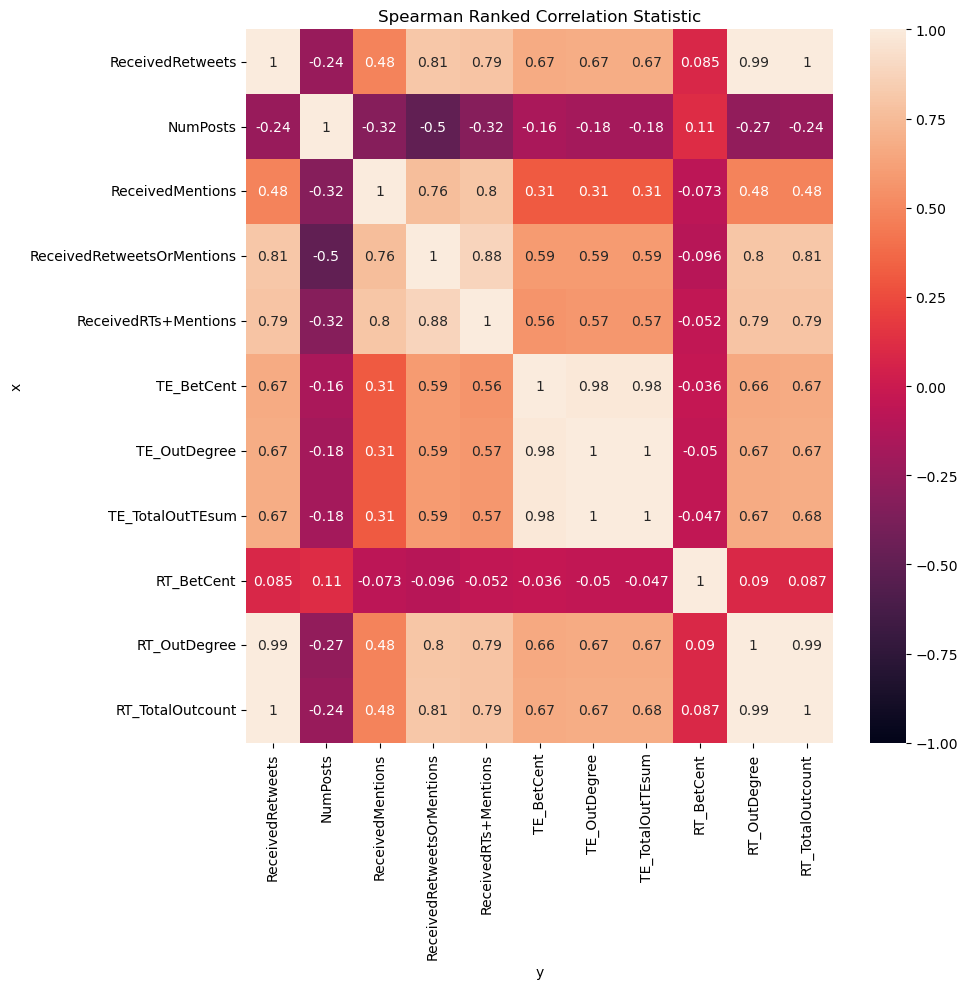

In [47]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(srcpivot, vmin=-1, vmax=1, annot=True)
plt.title("Spearman Ranked Correlation Statistic")
plt.tight_layout()
plt.savefig("Spearman Ranked Correlation Statistic.png")

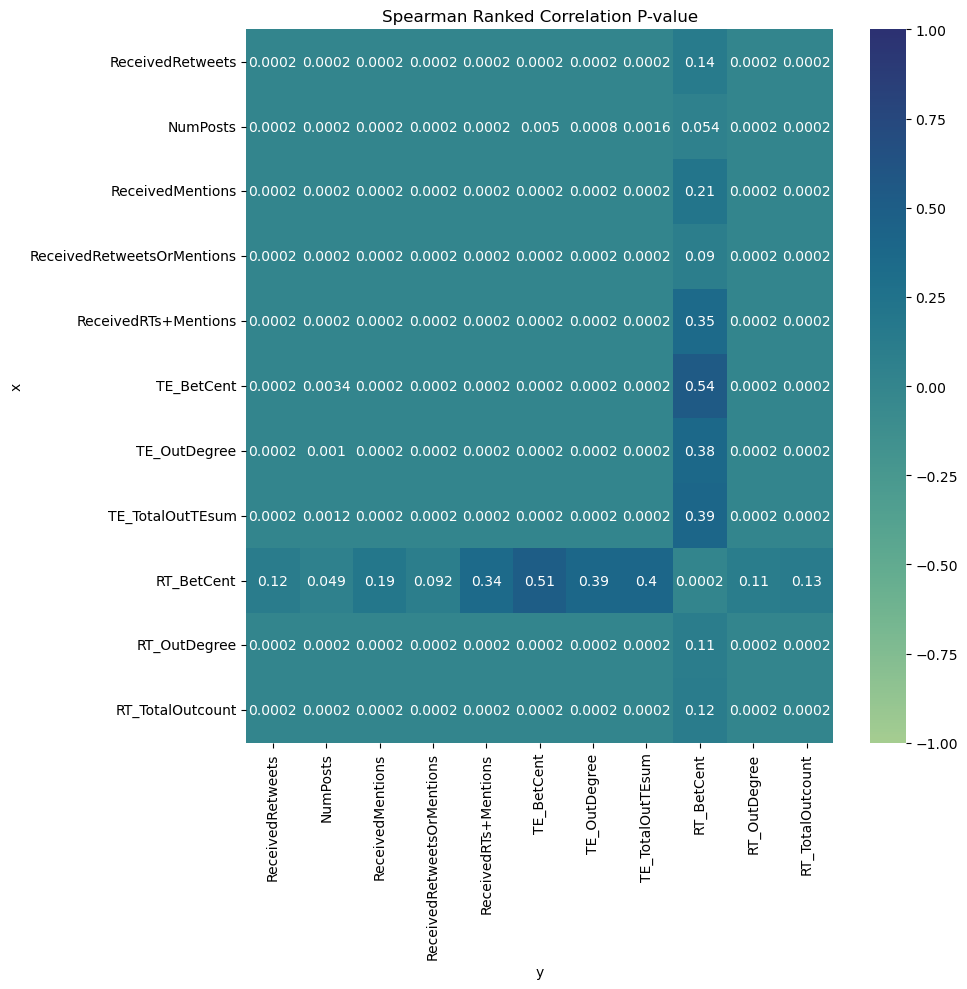

In [46]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(srcpivot2, vmin=-1, vmax=1, annot=True, cmap="crest")
plt.title("Spearman Ranked Correlation P-value")
plt.tight_layout()
plt.savefig("Spearman Ranked Correlation P-value.png")

[1, 4, 3, 2, 5]
[1, 4, 3, 2, 5]


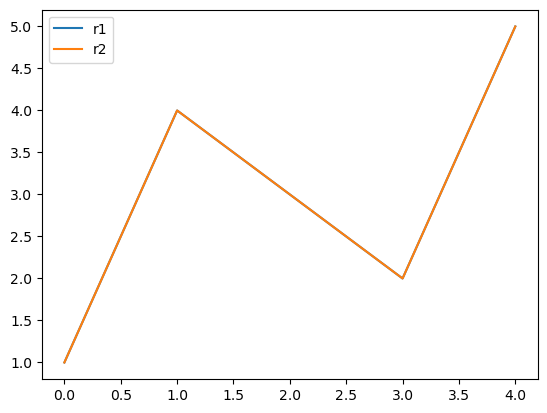

SignificanceResult(statistic=0.9999999999999999, pvalue=1.4042654220543672e-24)

In [48]:
r1 = [1,4,3,2,5] #df['TotalOutTE']
r2 = [1,4,3,2,5]
print(r1)
print(r2)
plt.plot(r1, label='r1')
plt.plot(r2, label='r2')
plt.legend()
plt.show()
r = stats.spearmanr(r1,r2)
r